In [23]:
# Configure libraries

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


%matplotlib inline

In [14]:
# Reading the data
df = pd.read_csv('~/Dissertation/data/joined_final_incl_clusters.csv') # entire data
df_features = pd.read_csv('~/Dissertation/data/data_joined_final_FEATURES_ONLY.csv') # features only

# Create individual target variables
Y_antibiotics = df[['antibiotics']]
Y_class = df[['Class']]
Y_cluster = df[['cluster']]

In [15]:
X_ = df_features.values
X_.shape

(16421, 688)

In [16]:
Y_anti = Y_antibiotics.values.reshape(16421,)
Y_anti

array([1, 1, 0, ..., 1, 1, 1])

### Train and Test Data

In [17]:
X = X_
y = Y_anti

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

### Baseline Predictor

In [6]:
dummy = DummyClassifier(strategy='uniform')
dummy.fit(X_train_std, y_train)

dummy_pred = dummy.predict(X_test_std)
print('Misclassified samples: %d' %(dummy_pred != y_test).sum())
print('Accuracy: %.2f' %accuracy_score(y_test, dummy_pred))

Misclassified samples: 2471
Accuracy: 0.50


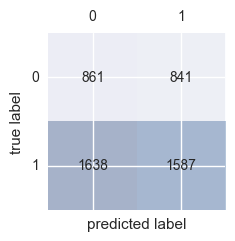

In [52]:
confmat = confusion_matrix(y_true=y_test, y_pred=dummy_pred)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.savefig('./Dissertation/data/confusion_matrix_dummy.png', dpi=300)
plt.show()

### Perceptron

In [92]:
from sklearn.linear_model import Perceptron
ppn = Perceptron(n_iter=40, eta0=0.1, random_state=0)
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      n_iter=40, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

In [98]:
ppn_pred = ppn.predict(X_test_std)

print('Misclassified samples: %d' %(ppn_pred != y_test).sum())
print('Accuracy: %.2f' %accuracy_score(y_test, ppn_pred))

Misclassified samples: 958
Accuracy: 0.81


#### This model has a misclassification error (or classification accuracy) of 81 percent. 958 samples out of 16,421 were misclassified.

### Logistic Regression

In [96]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(X_train_std, y_train)

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [99]:
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.859143901166
Test accuracy: 0.8498071849


#### There doesn't seem to be any overfitting as training and test accuracy are similar.

### Logistic Regression - GridSearch

In [10]:
%%time

# defining a grid of parameters over which to optimize the lr classifier

params = [{'penalty': ['l1','l2'], 
           'C': [0.001, 0.01, 1, 10, 100, 1000],  
           'n_jobs': [-1]}]
lr = LogisticRegression(n_jobs = -1)

gs_lr = GridSearchCV(lr, params, cv =10)
gs_lr = gs_lr.fit(X_train_std, y_train)

print('Best Accuracy: %.3f' %gs_lr.best_score_)
print(gs_lr.best_params_)

Best Accuracy: 0.853
{'C': 1, 'n_jobs': -1, 'penalty': 'l2'}
CPU times: user 1h 33min 59s, sys: 21.8 s, total: 1h 34min 21s
Wall time: 1h 34min 51s


In [18]:
lr_best = LogisticRegression(n_jobs = -1,C=1,penalty='l2')
lr_best.fit(X_train_std, y_train)
lr_pred_best = lr_best.predict(X_test_std)


print('Misclassified samples: %d' %(lr_pred_best != y_test).sum())
print('Accuracy: %.2f' %accuracy_score(y_test, lr_pred_best))

Misclassified samples: 694
Accuracy: 0.86


In [19]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=lr_pred_best)
print(confmat)

[[1279  415]
 [ 279 2954]]


### Logistic Regression Confusion Matrix

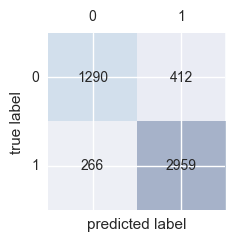

In [29]:
confmat = confusion_matrix(y_true=y_test, y_pred=lr_pred_best)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.savefig('./Dissertation/data/confusion_matrix_lr.png', dpi=300)
plt.show()

### SVM

In [168]:
from sklearn.svm import SVC
svm = LinearSVC(loss='hinge', C=1.0, random_state=0)
svm.fit(X_train_std, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=0, tol=0.0001, verbose=0)

In [170]:
svm_pred = svm.predict(X_test_std)

print('Misclassified samples: %d' %(svm_pred != y_test).sum())
print('Accuracy: %.2f' %accuracy_score(y_test, svm_pred))

Misclassified samples: 731
Accuracy: 0.85


### Random Forest Classifier

In [103]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion = 'entropy', n_estimators=10, random_state=1, n_jobs=2)
rf.fit(X_train_std, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

In [104]:
rf_pred = rf.predict(X_test_std)

print('Misclassified samples: %d' %(rf_pred != y_test).sum())
print('Accuracy: %.2f' %accuracy_score(y_test, rf_pred))

Misclassified samples: 2360
Accuracy: 0.52


### Random Forest GridSearch

In [158]:
%%time

# GridSearch: defining a grid of parameters over which to optimize the rf classifier

params = [{'n_estimators': [100,200], 
           'max_features': ['auto'], 
           'max_depth': [30,50], 
           'oob_score': [True, False]}]
rf = RandomForestClassifier(n_jobs = -1)

gs_rf = GridSearchCV(rf, params, cv =10)
gs_rf = gs_rf.fit(X_train_std, y_train)

print('Best Accuracy: %.3f' %gs_rf.best_score_)
print(gs_rf.best_params_)

Best Accuracy: 0.944
{'max_depth': 50, 'n_estimators': 100, 'max_features': 'auto', 'oob_score': True}
CPU times: user 15min 31s, sys: 26.1 s, total: 15min 57s
Wall time: 5min 23s


In [21]:
rf_best = RandomForestClassifier(max_depth=50, n_estimators=100, max_features='auto', oob_score=True, n_jobs = -1)
rf_best.fit(X_train_std, y_train)
rf_pred_best = rf_best.predict(X_test_std)


print('Misclassified samples: %d' %(rf_pred_best != y_test).sum())
print('Accuracy: %.2f' %accuracy_score(y_test, rf_pred_best))

Misclassified samples: 267
Accuracy: 0.95


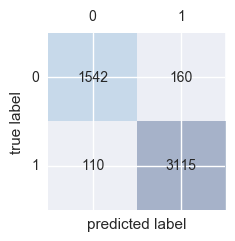

In [34]:
confmat = confusion_matrix(y_true=y_test, y_pred=rf_pred_best)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.savefig('./Dissertation/data/confusion_matrix_rf.png', dpi=300)
plt.show()

#### Assessing feature importance with random forests

In [73]:
feat_labels = df_features.columns

importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) PRED_DDG                       0.218484
 2) RSA                            0.209139
 3) F296                           0.012119
 4) F397                           0.010080
 5) F237                           0.008647
 6) F461                           0.007825
 7) F219                           0.007739
 8) F348                           0.006679
 9) F115                           0.005900
10) F25                            0.005719
11) F217                           0.005493
12) F306                           0.005114
13) F510                           0.005104
14) F383                           0.005082
15) F554                           0.005012
16) F439                           0.004869
17) F286                           0.004819
18) F153                           0.004785
19) F445                           0.004744
20) F327                           0.004540
21) F74                            0.004426
22) F60                            0.004371
23) F462                        

In [77]:
importances[indices[:10]]

array([ 0.21848424,  0.20913946,  0.01211855,  0.01008009,  0.00864736,
        0.00782487,  0.00773858,  0.00667886,  0.00590018,  0.00571944])

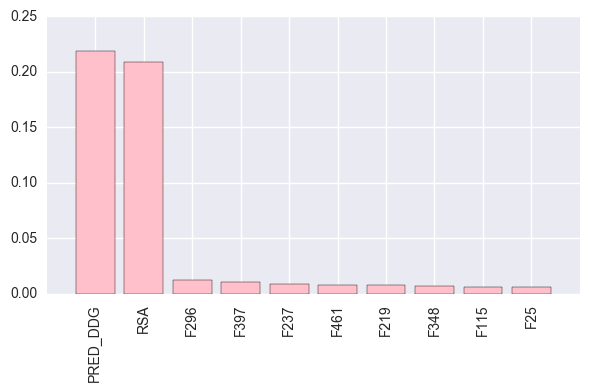

In [90]:
plt.bar(range(10),
       importances[indices[:10]],
       color='pink',
       align='center')
plt.xticks(range(10),
          feat_labels[indices[:10]],
          rotation=90)
plt.xlim([-1, 10])
plt.tight_layout()
plt.savefig('./Dissertation/data/variable_importance_rf.png', dpi=300)
plt.show()

#### PRED_DDG and RSA are the most discriminative features in the dataset based on the average impurity decrease in the 10,000 decision trees.

### KNN

In [ ]:
gs = GridSearchCV(estimator=KNeighborsClassifier)

In [19]:
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [108]:
knn_pred = knn.predict(X_test_std)

print('Misclassified samples: %d' %(knn_pred != y_test).sum())
print('Accuracy: %.2f' %accuracy_score(y_test, knn_pred))

Misclassified samples: 323
Accuracy: 0.93


### kNN GridSearch

In [148]:
%%time

# GridSearch: defining a grid of parameters over which to optimize the knn classifier

params = [{'n_neighbors': [5, 10, 20], 
           'weights': ['uniform', 'distance'],  
           'n_jobs': [-1]}]
clf = KNeighborsClassifier(n_jobs = -1)

gs = GridSearchCV(clf, params, cv =10)
gs = gs.fit(X_train_std, y_train)

print('Best Accuracy: %.3f' %gs.best_score_)
print(gs.best_params_)

Best Accuracy: 0.933
{'n_jobs': -1, 'weights': 'distance', 'n_neighbors': 5}
CPU times: user 8min 57s, sys: 9.47 s, total: 9min 6s
Wall time: 3min 7s


In [25]:
knn_best = KNeighborsClassifier(n_jobs = -1,weights='distance',n_neighbors=5)
knn_best.fit(X_train_std, y_train)
knn_pred_best = knn_best.predict(X_test_std)


print('Misclassified samples: %d' %(knn_pred_best != y_test).sum())
print('Accuracy: %.2f' %accuracy_score(y_test, knn_pred_best))

Misclassified samples: 281
Accuracy: 0.94


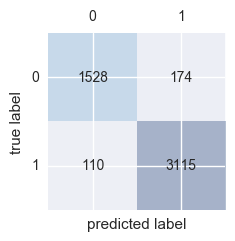

In [25]:
confmat = confusion_matrix(y_true=y_test, y_pred=knn_pred_best)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.savefig('./Dissertation/data/confusion_matrix_knn.png', dpi=300)
plt.show()

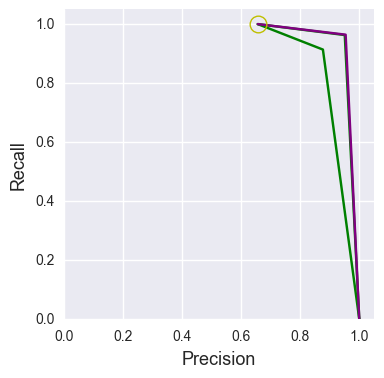

In [65]:
from sklearn.metrics import precision_recall_curve

P_lr, R_lr, T_lr = precision_recall_curve(y_test, lr_pred_best)
P_knn, R_knn, T_knn = precision_recall_curve(y_test, knn_pred_best)
P_rf, R_rf, T_rf = precision_recall_curve(y_test, rf_pred_best)

cz_lr = np.argmin(np.abs(T_lr))
cz_lr_p = P_lr[cz_lr]
cz_lr_r = R_lr[cz_lr]


plt.figure()
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.plot(P_lr, R_lr, 'green')
plt.plot(P_knn, R_knn,c='green')
plt.plot(P_rf, R_rf,c='purple')
plt.plot(cz_lr_p, cz_lr_r, 'o', markersize = 12, fillstyle = 'none', c='y', mew=1)
plt.xlabel('Precision', fontsize=13)
plt.ylabel('Recall', fontsize=13)
plt.axes().set_aspect('equal')
plt.show()

### Precision and Recall

In [53]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print('Precision LR: %.3f' % precision_score(y_true=y_test, y_pred=lr_pred_best))
print('Recall LR: %.3f' % recall_score(y_true=y_test, y_pred=lr_pred_best))

print('Precision SVM: %.3f' % precision_score(y_true=y_test, y_pred=svm_pred_best))
print('Recall SVM: %.3f' % recall_score(y_true=y_test, y_pred=svm_pred_best))

print('Precision kNN: %.3f' % precision_score(y_true=y_test, y_pred=knn_pred_best))
print('Recall kNN: %.3f' % recall_score(y_true=y_test, y_pred=knn_pred_best))

print('Precision RF: %.3f' % precision_score(y_true=y_test, y_pred=rf_pred_best))
print('Recall RF: %.3f' % recall_score(y_true=y_test, y_pred=rf_pred_best))

print('Precision Dummy: %.3f' % precision_score(y_true=y_test, y_pred=dummy_pred))
print('Recall Dummy: %.3f' % recall_score(y_true=y_test, y_pred=dummy_pred))

Precision LR: 0.878
Recall LR: 0.918
Precision SVM: 0.881
Recall SVM: 0.911
Precision kNN: 0.947
Recall kNN: 0.966
Precision RF: 0.951
Recall RF: 0.966
Precision Dummy: 0.654
Recall Dummy: 0.492
